In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/github_raw_features.csv")
print(f"Shape: {df.shape}")
print(df.describe())

Shape: (599, 14)
       commit_frequency  activity_consistency  commit_trend  \
count        599.000000            599.000000    599.000000   
mean          17.118146              8.290290     -0.055839   
std           77.907205             23.848663      0.842490   
min            0.000000              0.000000    -15.442500   
25%            0.038500              0.249850     -0.043925   
50%            1.403800              2.670800      0.000000   
75%           10.653850              8.681900      0.007214   
max         1550.692300            449.187800      5.153249   

       active_days_ratio  peak_to_average_ratio  recent_vs_past_ratio  \
count         599.000000             599.000000          5.990000e+02   
mean            0.468215               9.885091          1.252087e+08   
std             0.411794              13.381293          8.569111e+08   
min             0.000000               0.000000          0.000000e+00   
25%             0.038500               1.839650   

In [ ]:
print("Missing values:")
print(df.isnull().sum())

df["recent_vs_past_ratio"] = df["recent_vs_past_ratio"].clip(upper=10)

print(f"\ncommit_frequency > 100: {(df['commit_frequency'] > 100).sum()} repo")
print(f"commit_frequency > 50:  {(df['commit_frequency'] > 50).sum()} repo")

print("\nRepo dengan commit_frequency tertinggi:")
print(df.nlargest(5, "commit_frequency")[["full_name", "commit_frequency"]])

df = df[df["commit_frequency"] <= 200].reset_index(drop=True)
print(f"\nShape setelah drop outlier: {df.shape}")

Missing values:
full_name                0
commit_frequency         0
activity_consistency     0
commit_trend             0
active_days_ratio        0
peak_to_average_ratio    0
recent_vs_past_ratio     0
velocity_stability       0
has_description          0
has_license              0
forks_count              0
open_issues_count        0
stars                    0
commit_count_total       0
dtype: int64

commit_frequency > 100: 19 repo
commit_frequency > 50:  40 repo

Repo dengan commit_frequency tertinggi:
                 full_name  commit_frequency
531         torvalds/linux         1550.6923
226  ClickHouse/ClickHouse          825.7692
202        swiftlang/swift          275.6731
536        PostHog/posthog          273.4808
486       JetBrains/kotlin          213.4423

Shape setelah drop outlier: (594, 14)


In [3]:
def label_productivity(row):
    freq  = row["commit_frequency"]
    ratio = row["active_days_ratio"]
    cons  = row["activity_consistency"]

    if freq >= 2.0 and ratio >= 0.5 and cons <= 3.0:
        return "Active"
    elif freq < 0.5 or ratio < 0.15:
        return "Inactive"
    else:
        return "Moderate"

df["productivity_label"] = df.apply(label_productivity, axis=1)

print("Distribusi label:")
print(df["productivity_label"].value_counts())
print("\nDistribusi (%):")
print((df["productivity_label"].value_counts(normalize=True) * 100).round(1))

Distribusi label:
productivity_label
Moderate    348
Inactive    238
Active        8
Name: count, dtype: int64

Distribusi (%):
productivity_label
Moderate    58.6
Inactive    40.1
Active       1.3
Name: proportion, dtype: float64


In [ ]:
def label_productivity(row):
    freq  = row["commit_frequency"]
    ratio = row["active_days_ratio"]
    cons  = row["activity_consistency"]

    if freq >= 1.0 and ratio >= 0.3:
        return "Active"
    
    elif freq < 0.1 or ratio < 0.05:
        return "Inactive"
    
    else:
        return "Moderate"

df["productivity_label"] = df.apply(label_productivity, axis=1)

print("Distribusi label:")
print(df["productivity_label"].value_counts())
print("\nDistribusi (%):")
print((df["productivity_label"].value_counts(normalize=True) * 100).round(1))

Distribusi label:
productivity_label
Active      305
Inactive    182
Moderate    107
Name: count, dtype: int64

Distribusi (%):
productivity_label
Active      51.3
Inactive    30.6
Moderate    18.0
Name: proportion, dtype: float64


In [ ]:
def label_productivity(row):
    freq  = row["commit_frequency"]
    ratio = row["active_days_ratio"]
    cons  = row["activity_consistency"]

    if freq >= 2.0 and ratio >= 0.5:
        return "Active"
    
    elif freq < 0.1 or ratio < 0.05:
        return "Inactive"
    
    else:
        return "Moderate"

df["productivity_label"] = df.apply(label_productivity, axis=1)

print("Distribusi label:")
print(df["productivity_label"].value_counts())
print("\nDistribusi (%):")
print((df["productivity_label"].value_counts(normalize=True) * 100).round(1))

Distribusi label:
productivity_label
Active      258
Inactive    182
Moderate    154
Name: count, dtype: int64

Distribusi (%):
productivity_label
Active      43.4
Inactive    30.6
Moderate    25.9
Name: proportion, dtype: float64


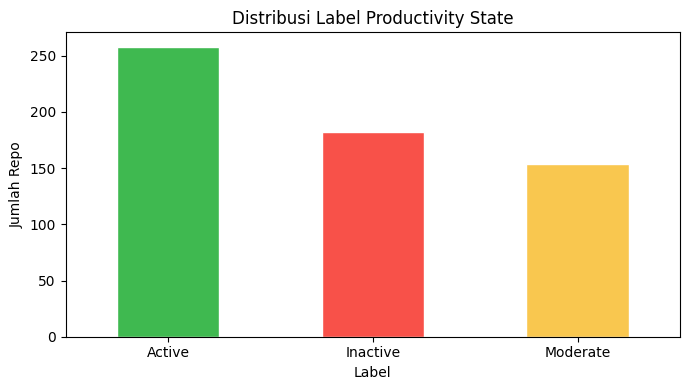

In [6]:
plt.figure(figsize=(7, 4))
colors_map = {"Active": "#3FB950", "Moderate": "#F9C74F", "Inactive": "#F85149"}
vals = df["productivity_label"].value_counts()
vals.plot(kind="bar", color=[colors_map[l] for l in vals.index], edgecolor="white")
plt.title("Distribusi Label Productivity State")
plt.xlabel("Label")
plt.ylabel("Jumlah Repo")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../data/productivity_distribution.png", dpi=150)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

FEATURES = ["commit_frequency", "activity_consistency",
            "commit_trend", "active_days_ratio"]

X = df[FEATURES]
y = df["productivity_label"]

sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)
print(f"Sebelum SMOTE: {y.value_counts().to_dict()}")
print(f"Setelah SMOTE: {pd.Series(y_bal).value_counts().to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

Sebelum SMOTE: {'Active': 258, 'Inactive': 182, 'Moderate': 154}
Setelah SMOTE: {'Active': 258, 'Moderate': 258, 'Inactive': 258}

=== Classification Report ===
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00        51
    Inactive       0.98      1.00      0.99        52
    Moderate       1.00      0.98      0.99        52

    accuracy                           0.99       155
   macro avg       0.99      0.99      0.99       155
weighted avg       0.99      0.99      0.99       155



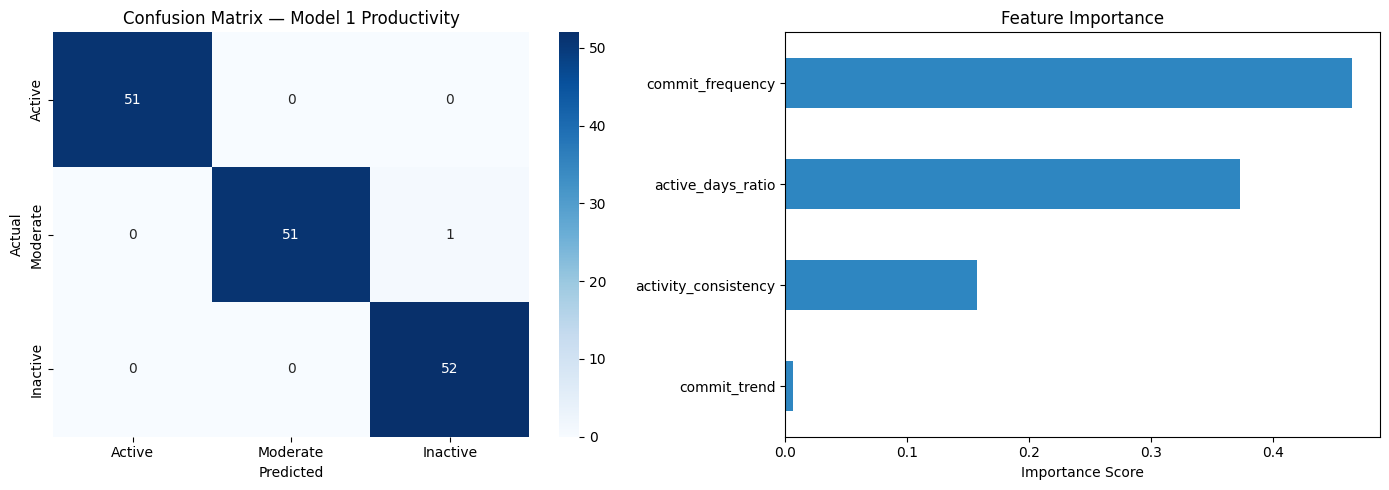

Cross Validation Accuracy: 0.995 ± 0.006


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, y_pred, labels=["Active", "Moderate", "Inactive"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Active", "Moderate", "Inactive"],
            yticklabels=["Active", "Moderate", "Inactive"], ax=axes[0])
axes[0].set_title("Confusion Matrix — Model 1 Productivity")
axes[0].set_ylabel("Actual")
axes[0].set_xlabel("Predicted")

importance = pd.Series(model.feature_importances_, index=FEATURES).sort_values()
importance.plot(kind="barh", color="#2E86C1", ax=axes[1])
axes[1].set_title("Feature Importance")
axes[1].set_xlabel("Importance Score")

plt.tight_layout()
plt.savefig("../data/model1_evaluation.png", dpi=150)
plt.show()

cv = cross_val_score(model, X_bal, y_bal, cv=5, scoring="accuracy")
print(f"Cross Validation Accuracy: {cv.mean():.3f} ± {cv.std():.3f}")

In [ ]:
joblib.dump(model, "../models/model1_productivity.pkl")
print("✅ Model tersimpan!")

loaded = joblib.load("../models/model1_productivity.pkl")
test_cases = pd.DataFrame([
    {"commit_frequency": 5.0,  "activity_consistency": 1.5, "commit_trend": 0.1,  "active_days_ratio": 0.8},
    {"commit_frequency": 0.5,  "activity_consistency": 1.2, "commit_trend": -0.1, "active_days_ratio": 0.3},
    {"commit_frequency": 0.05, "activity_consistency": 0.1, "commit_trend": -0.5, "active_days_ratio": 0.02},
])
print("\nTest prediksi:")
for i, pred in enumerate(loaded.predict(test_cases)):
    print(f"  Case {i+1}: {pred}")

✅ Model tersimpan!

Test prediksi:
  Case 1: Active
  Case 2: Moderate
  Case 3: Inactive
